In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

# 1. 장치 설정 (GPU 사용 가능 시 GPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. 데이터 전처리 설정 (크기 및 정규화 통일)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # MobileNet 모델은 224x224 입력 크기 사용
    transforms.ToTensor()
])

# 3. 사용자 데이터셋 불러오기"C:\Users\USER\Desktop\Semester2\train_data"
trainset_path = 'C:/Users/USER/Desktop/Semester2/train_data'
user_dataset = datasets.ImageFolder(root=trainset_path, transform=transform)

# 4. CIFAR-10 데이터셋 불러오기 (훈련 데이터만 사용)
cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)

# 5. 사용자 데이터셋과 CIFAR-10 데이터셋 통합
combined_dataset = ConcatDataset([user_dataset, cifar10_dataset])
combined_labels = np.concatenate((np.array([label for _, label in user_dataset.samples]),
                                  np.array(cifar10_dataset.targets)))

# 6. K-Fold Cross Validation 설정
k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
fold_accuracies_mobilenet = []  # MobileNet v2 각 폴드 정확도 저장

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data


In [4]:
# CIFAR-10의 학습 데이터는 50,000장이고, 사용자 데이터셋의 이미지 수를 계산
user_data_size = len(user_dataset)    # 사용자 데이터셋의 이미지 수
cifar10_data_size = len(cifar10_dataset)  # CIFAR-10 학습 데이터셋의 이미지 수

# 합쳐진 combined_dataset의 전체 이미지 수
combined_data_size = len(combined_dataset)

# 데이터셋 개수 출력
print(f"사용자 데이터셋 이미지 수: {user_data_size}")
print(f"CIFAR-10 데이터셋 이미지 수: {cifar10_data_size}")
print(f"합쳐진 데이터셋 이미지 수: {combined_data_size}")

# 이미지 수가 54,000장인지 확인
if combined_data_size == 54000:
    print("데이터셋이 제대로 합쳐졌습니다. 총 이미지 수는 54,000장입니다.")
else:
    print(f"데이터셋이 제대로 합쳐지지 않았습니다. 총 이미지 수는 {combined_data_size}장입니다.")

사용자 데이터셋 이미지 수: 4000
CIFAR-10 데이터셋 이미지 수: 50000
합쳐진 데이터셋 이미지 수: 54000
데이터셋이 제대로 합쳐졌습니다. 총 이미지 수는 54,000장입니다.


CIFAR-10 클래스 순서:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [12]:
# CIFAR-10의 클래스 순서
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 사용자 데이터셋 클래스 확인
user_dataset_classes = user_dataset.classes  # ImageFolder에서 자동 생성된 클래스 리스트

print("CIFAR-10 클래스 순서:", cifar10_classes)
print("사용자 데이터셋 클래스 순서:", user_dataset_classes)


CIFAR-10 클래스 순서: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
사용자 데이터셋 클래스 순서: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [19]:
# 7. MobileNet v2 Cross Validation 학습 및 평가
for fold, (train_idx, val_idx) in enumerate(kf.split(np.zeros(len(combined_labels)), combined_labels)):
    print(f"\n=== MobileNet v2 Fold {fold + 1} 시작 ===")

    # Fold별 데이터셋 분리
    train_subset = Subset(combined_dataset, train_idx)
    val_subset = Subset(combined_dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=0)

    # MobileNet v2 모델 설정
    mobilenet_v2 = models.mobilenet_v2(pretrained=False)
    num_classes = 10  # CIFAR-10과 동일하게 10개 클래스
    mobilenet_v2.classifier[1] = nn.Linear(mobilenet_v2.classifier[1].in_features, num_classes)
    mobilenet_v2 = mobilenet_v2.to(device)

    # 손실 함수 및 옵티마이저 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(mobilenet_v2.parameters(), lr=0.001)

    # MobileNet v2 학습
    num_epochs = 25  # 예시로 10 에포크
    mobilenet_v2.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = mobilenet_v2(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"MobileNet v2 Fold [{fold + 1}], Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # MobileNet v2 검증
    mobilenet_v2.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = mobilenet_v2(images)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.numpy())

    # MobileNet v2 검증 정확도 계산 및 저장
    fold_accuracy_mobilenet = accuracy_score(val_labels, val_preds)
    fold_accuracies_mobilenet.append(fold_accuracy_mobilenet)
    print(f"MobileNet v2 Fold {fold + 1} Accuracy: {fold_accuracy_mobilenet * 100:.2f}%")

# 최종 K-Fold 평균 정확도 출력
print("\n=== MobileNet v2 최종 K-Fold 평균 정확도 ===")
print(f"MobileNet v2 Average {k}-Fold Accuracy: {np.mean(fold_accuracies_mobilenet) * 100:.2f}%")


=== MobileNet v2 Fold 1 시작 ===


c:\Users\jongcheol\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jongcheol\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNet v2 Fold [1], Epoch [1/25], Loss: 1.4359
MobileNet v2 Fold [1], Epoch [2/25], Loss: 0.9679
MobileNet v2 Fold [1], Epoch [3/25], Loss: 0.7715
MobileNet v2 Fold [1], Epoch [4/25], Loss: 0.6588
MobileNet v2 Fold [1], Epoch [5/25], Loss: 0.5672
MobileNet v2 Fold [1], Epoch [6/25], Loss: 0.4973
MobileNet v2 Fold [1], Epoch [7/25], Loss: 0.4355
MobileNet v2 Fold [1], Epoch [8/25], Loss: 0.3860
MobileNet v2 Fold [1], Epoch [9/25], Loss: 0.3354
MobileNet v2 Fold [1], Epoch [10/25], Loss: 0.2984
MobileNet v2 Fold [1], Epoch [11/25], Loss: 0.2595
MobileNet v2 Fold [1], Epoch [12/25], Loss: 0.2323
MobileNet v2 Fold [1], Epoch [13/25], Loss: 0.2067
MobileNet v2 Fold [1], Epoch [14/25], Loss: 0.1876
MobileNet v2 Fold [1], Epoch [15/25], Loss: 0.1659
MobileNet v2 Fold [1], Epoch [16/25], Loss: 0.1549
MobileNet v2 Fold [1], Epoch [17/25], Loss: 0.1414
MobileNet v2 Fold [1], Epoch [18/25], Loss: 0.1287
MobileNet v2 Fold [1], Epoch [19/25], Loss: 0.1232
MobileNet v2 Fold [1], Epoch [20/25], Lo

c:\Users\jongcheol\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jongcheol\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNet v2 Fold [2], Epoch [1/25], Loss: 1.4363
MobileNet v2 Fold [2], Epoch [2/25], Loss: 0.9778
MobileNet v2 Fold [2], Epoch [3/25], Loss: 0.7764
MobileNet v2 Fold [2], Epoch [4/25], Loss: 0.6640
MobileNet v2 Fold [2], Epoch [5/25], Loss: 0.5801
MobileNet v2 Fold [2], Epoch [6/25], Loss: 0.5046
MobileNet v2 Fold [2], Epoch [7/25], Loss: 0.4457
MobileNet v2 Fold [2], Epoch [8/25], Loss: 0.3938
MobileNet v2 Fold [2], Epoch [9/25], Loss: 0.3516
MobileNet v2 Fold [2], Epoch [10/25], Loss: 0.3126
MobileNet v2 Fold [2], Epoch [11/25], Loss: 0.2717
MobileNet v2 Fold [2], Epoch [12/25], Loss: 0.2431
MobileNet v2 Fold [2], Epoch [13/25], Loss: 0.2115
MobileNet v2 Fold [2], Epoch [14/25], Loss: 0.1983
MobileNet v2 Fold [2], Epoch [15/25], Loss: 0.1748
MobileNet v2 Fold [2], Epoch [16/25], Loss: 0.1612
MobileNet v2 Fold [2], Epoch [17/25], Loss: 0.1491
MobileNet v2 Fold [2], Epoch [18/25], Loss: 0.1313
MobileNet v2 Fold [2], Epoch [19/25], Loss: 0.1242
MobileNet v2 Fold [2], Epoch [20/25], Lo

c:\Users\jongcheol\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jongcheol\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNet v2 Fold [3], Epoch [1/25], Loss: 1.4387
MobileNet v2 Fold [3], Epoch [2/25], Loss: 0.9624
MobileNet v2 Fold [3], Epoch [3/25], Loss: 0.7562
MobileNet v2 Fold [3], Epoch [4/25], Loss: 0.6437
MobileNet v2 Fold [3], Epoch [5/25], Loss: 0.5658
MobileNet v2 Fold [3], Epoch [6/25], Loss: 0.4912
MobileNet v2 Fold [3], Epoch [7/25], Loss: 0.4255
MobileNet v2 Fold [3], Epoch [8/25], Loss: 0.3758
MobileNet v2 Fold [3], Epoch [9/25], Loss: 0.3294
MobileNet v2 Fold [3], Epoch [10/25], Loss: 0.2905
MobileNet v2 Fold [3], Epoch [11/25], Loss: 0.2552
MobileNet v2 Fold [3], Epoch [12/25], Loss: 0.2253
MobileNet v2 Fold [3], Epoch [13/25], Loss: 0.1994
MobileNet v2 Fold [3], Epoch [14/25], Loss: 0.1823
MobileNet v2 Fold [3], Epoch [15/25], Loss: 0.1597
MobileNet v2 Fold [3], Epoch [16/25], Loss: 0.1493
MobileNet v2 Fold [3], Epoch [17/25], Loss: 0.1314
MobileNet v2 Fold [3], Epoch [18/25], Loss: 0.1266
MobileNet v2 Fold [3], Epoch [19/25], Loss: 0.1212
MobileNet v2 Fold [3], Epoch [20/25], Lo

c:\Users\jongcheol\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jongcheol\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNet v2 Fold [4], Epoch [1/25], Loss: 1.4553
MobileNet v2 Fold [4], Epoch [2/25], Loss: 0.9912
MobileNet v2 Fold [4], Epoch [3/25], Loss: 0.7898
MobileNet v2 Fold [4], Epoch [4/25], Loss: 0.6607
MobileNet v2 Fold [4], Epoch [5/25], Loss: 0.5666
MobileNet v2 Fold [4], Epoch [6/25], Loss: 0.4983
MobileNet v2 Fold [4], Epoch [7/25], Loss: 0.4344
MobileNet v2 Fold [4], Epoch [8/25], Loss: 0.3803
MobileNet v2 Fold [4], Epoch [9/25], Loss: 0.3322
MobileNet v2 Fold [4], Epoch [10/25], Loss: 0.2961
MobileNet v2 Fold [4], Epoch [11/25], Loss: 0.2525
MobileNet v2 Fold [4], Epoch [12/25], Loss: 0.2263
MobileNet v2 Fold [4], Epoch [13/25], Loss: 0.2032
MobileNet v2 Fold [4], Epoch [14/25], Loss: 0.1774
MobileNet v2 Fold [4], Epoch [15/25], Loss: 0.1612
MobileNet v2 Fold [4], Epoch [16/25], Loss: 0.1470
MobileNet v2 Fold [4], Epoch [17/25], Loss: 0.1373
MobileNet v2 Fold [4], Epoch [18/25], Loss: 0.1280
MobileNet v2 Fold [4], Epoch [19/25], Loss: 0.1172
MobileNet v2 Fold [4], Epoch [20/25], Lo

c:\Users\jongcheol\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jongcheol\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNet v2 Fold [5], Epoch [1/25], Loss: 1.4253
MobileNet v2 Fold [5], Epoch [2/25], Loss: 0.9670
MobileNet v2 Fold [5], Epoch [3/25], Loss: 0.7607
MobileNet v2 Fold [5], Epoch [4/25], Loss: 0.6466
MobileNet v2 Fold [5], Epoch [5/25], Loss: 0.5625
MobileNet v2 Fold [5], Epoch [6/25], Loss: 0.4884
MobileNet v2 Fold [5], Epoch [7/25], Loss: 0.4302
MobileNet v2 Fold [5], Epoch [8/25], Loss: 0.3735
MobileNet v2 Fold [5], Epoch [9/25], Loss: 0.3333
MobileNet v2 Fold [5], Epoch [10/25], Loss: 0.2936
MobileNet v2 Fold [5], Epoch [11/25], Loss: 0.2492
MobileNet v2 Fold [5], Epoch [12/25], Loss: 0.2278
MobileNet v2 Fold [5], Epoch [13/25], Loss: 0.2019
MobileNet v2 Fold [5], Epoch [14/25], Loss: 0.1770
MobileNet v2 Fold [5], Epoch [15/25], Loss: 0.1610
MobileNet v2 Fold [5], Epoch [16/25], Loss: 0.1457
MobileNet v2 Fold [5], Epoch [17/25], Loss: 0.1381
MobileNet v2 Fold [5], Epoch [18/25], Loss: 0.1279
MobileNet v2 Fold [5], Epoch [19/25], Loss: 0.1155
MobileNet v2 Fold [5], Epoch [20/25], Lo


=== Fold 1 시작 ===


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Fold [1], Epoch [1/12], Train Acc: 43.06%, Val Acc: 55.44%
Fold [1], Epoch [2/12], Train Acc: 65.00%, Val Acc: 71.82%
Fold [1], Epoch [3/12], Train Acc: 74.87%, Val Acc: 77.93%
Fold [1], Epoch [4/12], Train Acc: 80.34%, Val Acc: 79.87%
Fold [1], Epoch [5/12], Train Acc: 84.31%, Val Acc: 82.82%
Fold [1], Epoch [6/12], Train Acc: 88.00%, Val Acc: 84.55%
Fold [1], Epoch [7/12], Train Acc: 91.17%, Val Acc: 85.87%
Fold [1], Epoch [8/12], Train Acc: 94.15%, Val Acc: 86.89%
Fold [1], Epoch [9/12], Train Acc: 96.35%, Val Acc: 87.23%
Fold [1], Epoch [10/12], Train Acc: 97.29%, Val Acc: 87.40%
Fold [1], Epoch [11/12], Train Acc: 97.79%, Val Acc: 87.22%
Fold [1], Epoch [12/12], Train Acc: 97.72%, Val Acc: 87.26%

=== Fold 2 시작 ===
Fold [2], Epoch [1/12], Train Acc: 42.34%, Val Acc: 59.34%
Fold [2], Epoch [2/12], Train Acc: 64.42%, Val Acc: 72.57%
Fold [2], Epoch [3/12], Train Acc: 74.28%, Val Acc: 75.22%
Fold [2], Epoch [4/12], Train Acc: 79.79%, Val Acc: 80.50%
Fold [2], Epoch [5/12], Train Acc:

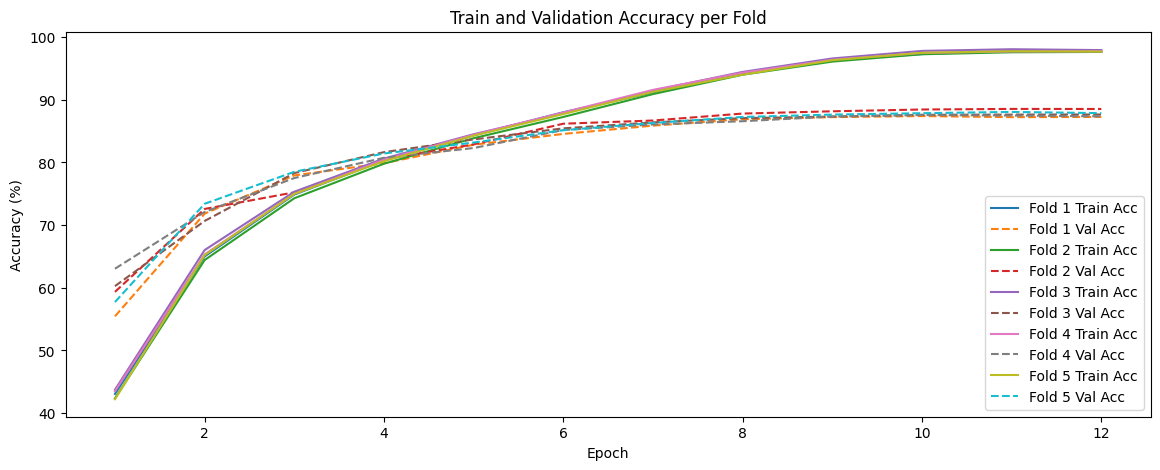

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset, Subset
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# 1. 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. 데이터 전처리 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet-B0는 224x224 입력 크기 사용
    transforms.ToTensor(),
    transforms.Normalize(mean=(0,), std=(0.5,))
])

# 3. 사용자 데이터셋 불러오기
trainset_path = 'C:/Users/USER/Desktop/Semester2/train_data'
user_dataset = datasets.ImageFolder(root=trainset_path, transform=transform)

# 4. CIFAR-10 데이터셋 불러오기 (훈련 데이터만 사용)
cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)

# 5. 사용자 데이터셋과 CIFAR-10 데이터셋 통합
combined_dataset = ConcatDataset([user_dataset, cifar10_dataset])
combined_labels = np.concatenate((np.array([label for _, label in user_dataset.samples]),
                                  np.array(cifar10_dataset.targets)))

# 6. K-Fold Cross Validation 설정
k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
fold_accuracies = []  # 각 폴드의 검증 정확도 저장
train_accuracies, val_accuracies = [], []  # 전체 에포크의 정확도 저장

# 7. Cross Validation 학습 및 평가
num_epochs = 12
for fold, (train_idx, val_idx) in enumerate(kf.split(np.zeros(len(combined_labels)), combined_labels)):
    print(f"\n=== Fold {fold + 1} 시작 ===")

    # Fold별 데이터셋 분리
    train_subset = Subset(combined_dataset, train_idx)
    val_subset = Subset(combined_dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=16, shuffle=False, num_workers=2)

    # EfficientNet-B0 모델 설정 (사전 학습 없음)
    model = models.efficientnet_b0(pretrained=False)
    num_classes = 10  # CIFAR-10의 클래스 수 (사용자 데이터셋도 동일한 클래스 수로 가정)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    model = model.to(device)

    # 손실 함수 및 옵티마이저 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 학습률 스케줄러 설정 (CosineAnnealingLR 사용)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

    # Fold 학습 및 검증
    fold_train_acc, fold_val_acc = [], []
    for epoch in range(num_epochs):
        # === 학습 ===
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        # 학습 정확도 기록
        train_acc = 100. * correct_train / total_train
        fold_train_acc.append(train_acc)

        # === 검증 ===
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

        # 검증 정확도 기록
        val_acc = 100. * correct_val / total_val
        fold_val_acc.append(val_acc)

        # 학습률 스케줄러 업데이트
        scheduler.step()

        print(f"Fold [{fold + 1}], Epoch [{epoch+1}/{num_epochs}], "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    # 각 폴드별 학습 및 검증 정확도 기록
    train_accuracies.append(fold_train_acc)
    val_accuracies.append(fold_val_acc)
    fold_accuracies.append(val_acc)  # 마지막 에포크의 검증 정확도 저장

# 8. 최종 K-Fold 평균 정확도 출력
print("\n=== 최종 K-Fold 평균 정확도 ===")
print(f"Average {k}-Fold Accuracy: {np.mean(fold_accuracies):.2f}%")

# 9. 정확도 시각화
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))

# 폴드별 학습 및 검증 정확도 변화 시각화
for i in range(k):
    plt.plot(epochs_range, train_accuracies[i], label=f'Fold {i+1} Train Acc')
    plt.plot(epochs_range, val_accuracies[i], label=f'Fold {i+1} Val Acc', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy per Fold')
plt.legend(loc='best')
plt.show()
